# Assignment 1 for PUI2016 Homework 6 
**Name:** Cheng Hou

**NetID:** ch3019

In [270]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
import statsmodels.formula.api as smf
import scipy.stats as st
import statsmodels.api as sm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")
else:
    print ("$PUIDATA exsits!")

$PUIDATA exsits!


## Download Data to PUIDTATA

In [44]:
def getEnergyData(url = 'https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD',\
                  filename = 'Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv'):
    if not os.path.exists(os.getenv("PUIDATA")):
        os.system("mkdir" + os.getenv("PUIDATA"))
        
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + filename):
        if os.path.isfile(filename):
            os.system("mv " + filename + " " + os.getenv("PUIDATA"))
        else:
            os.system("curl -o " + filename + " " + url)
            os.system("mv " + filename + " " + os.getenv("PUIDATA"))
            
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + filename):
        print ("WARNING!!! Something is wrong: No file is there!")
    else:
        print ("File is in $PUIDATA, filename:")
        print (" " + filename)

        return filename

In [159]:
def getMapPLUTO(borough = 'Manhattan'):
    url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/'
    zipname = 'mn_mappluto_16v1.zip'
    filename = 'MNMapPLUTO.shp'
    filelist = ['PLUTODD16v1.pdf',
                'mn_pluto.dbf',
                'mn_pluto.dbf.xml',
                'MN_Dcp_Mappinglot.dbf',
                'MN_Dcp_Mappinglot.prj',
                'MN_Dcp_Mappinglot.sbn',
                'MN_Dcp_Mappinglot.sbx',
                'MN_Dcp_Mappinglot.shp',
                'MN_Dcp_Mappinglot.shp.xml',
                'MN_Dcp_Mappinglot.shx',
                'MNMapPLUTO.BBL.atx',
                'MNMapPLUTO.CD.atx',
                'MNMapPLUTO.dbf',
                'MNMapPLUTO.LandUse.atx',
                'MNMapPLUTO.prj',
                'MNMapPLUTO.sbn',
                'MNMapPLUTO.sbx',
                'MNMapPLUTO.shp',
                'MNMapPLUTO.shp.xml',
                'MNMapPLUTO.shx',
                'MNMapPLUTO.ZoneDist1.atx']   
    boroughs = {'Manhattan': 'mn',
                'Brooklyn': 'bk',
                'Bronx': 'bx',
                'Queens': 'qn',
                'Staten Island': 'si'}
    
    if not (borough in boroughs.keys()):
        print ("Error: Illegal borough name")
        return 1
    
    n = len(filelist)
    if (borough != 'Manhattan'):
        c = boroughs[borough]
        C = c.upper()
        filename = C + filename
        zipname = c + zipname[2:]
        filelist[1] = c + filelist[1][2:]
        filelist[2] = c + filelist[2][2:]
        for i in range(3, n):
            filelist[i] = C + filelist[i][2:]
    
    if not os.path.exists(os.getenv("PUIDATA")):
        os.system("mkdir" + os.getenv("PUIDATA"))    
    if not os.path.exists(os.getenv("PUIDATA") + "/" + borough):
        os.system("mkdir" + os.getenv("PUIDATA") + "/" + borough)
        
    for i in range(n):
        if not os.path.isfile(os.getenv("PUIDATA") + "/" + filelist[i]):
            if os.path.isfile(filename):
                os.system("mv " + filelist[i] + " " + os.getenv("PUIDATA"))
            else:
                if not os.path.isfile(os.getenv("PUIDATA") + "/" + zipname):
                    if not os.path.isfile(zipname):
                        os.system("curl -o " + url + zipname)
                    os.system("mv " + zipname + " " + os.getenv("PUIDATA"))    

                os.system("unzip " + os.getenv("PUIDATA") + "/" + zipname + " " + filelist[i])
                os.system("mv " + filelist[i] + " " + os.getenv("PUIDATA"))
    
    print ("Files are in $PUIDATA")
    getMapPLUTO.filename = filename
    return 0

In [46]:
EnergyData = getEnergyData()

File is in $PUIDATA, filename:
 Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv


In [160]:
if (getMapPLUTO() == 0):
    GeoData = getMapPLUTO.filename

Files are in $PUIDATA


## Read Data

In [170]:
nrg = pd.read_csv(os.getenv("PUIDATA") + "/" + EnergyData, index_col = 0)
nrg.head(3)

,"NYC Borough, Block, and Lot (BBL)",Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Zip Code,DOF Benchmarking Submission Status,Site EUI(kBtu/ft2),...,Automatic Water Benchmarking Eligible,Reported Water Method,ENERGY STAR Score,Total GHG Emissions(MtCO2e),Direct GHG Emissions(MtCO2e),Indirect GHG Emissions(MtCO2e),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings
Record Number,,,,,,,,,,,,,,,,,,,,,
12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,918919,NaN,Office,NaN
14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,NaN,...,Yes,None,NaN,NaN,NaN,NaN,NaN,82730.0,NaN,1.0
12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,NaN,...,NaN,NaN,Not Available,NaN,NaN,NaN,64200,NaN,Multifamily Housing,NaN


In [171]:
print (nrg.shape)
print (nrg.columns)

(16170, 24)
Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


In [163]:
bsize = gp.read_file(os.getenv("PUIDATA") + "/" + GeoData)
bsize.head(3)

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,0.000000e+00,None,1592 2 AVENUE,C1-9/TA,None,2,468000.0,1435950.0,1.015450e+09,10885,...,0,1920,None,10028,C1-9,None,None,None,9a,"POLYGON ((997277.2344000041 221816.0936000049,..."
1,1.007230e+09,11/30/2006,263 9 AVENUE,C1-5/R8,None,2,539984.0,11879993.0,1.007238e+09,89203,...,0,1914,None,10001,R8,None,None,None,8d,"POLYGON ((984164.5626000017 211846.0703999996,..."
2,0.000000e+00,None,310 EAST 109 STREET,R7A,None,2,140102.0,343271.0,1.016800e+09,12000,...,0,1910,None,10029,R7A,None,None,None,6b,"POLYGON ((1000742.195800006 227910.6640000045,..."


In [165]:
print (bsize.shape)
print (bsize.columns)

(42697, 90)
Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea'

## Data Cleaning

In [173]:
nrg.rename(columns = {"NYC Borough, Block, and Lot (BBL)": "BBL"}, inplace = True)

In [174]:
nrg = nrg.loc[:,['BBL',
                 'Zip Code',
                 'DOF Property Floor Area (Buildngs and Parking)(ft2)',
                 'DOF Number of Buildings',
                 'Site EUI(kBtu/ft2)',
                 'Reported Property Floor Area (Building(s)) (ft²)']]

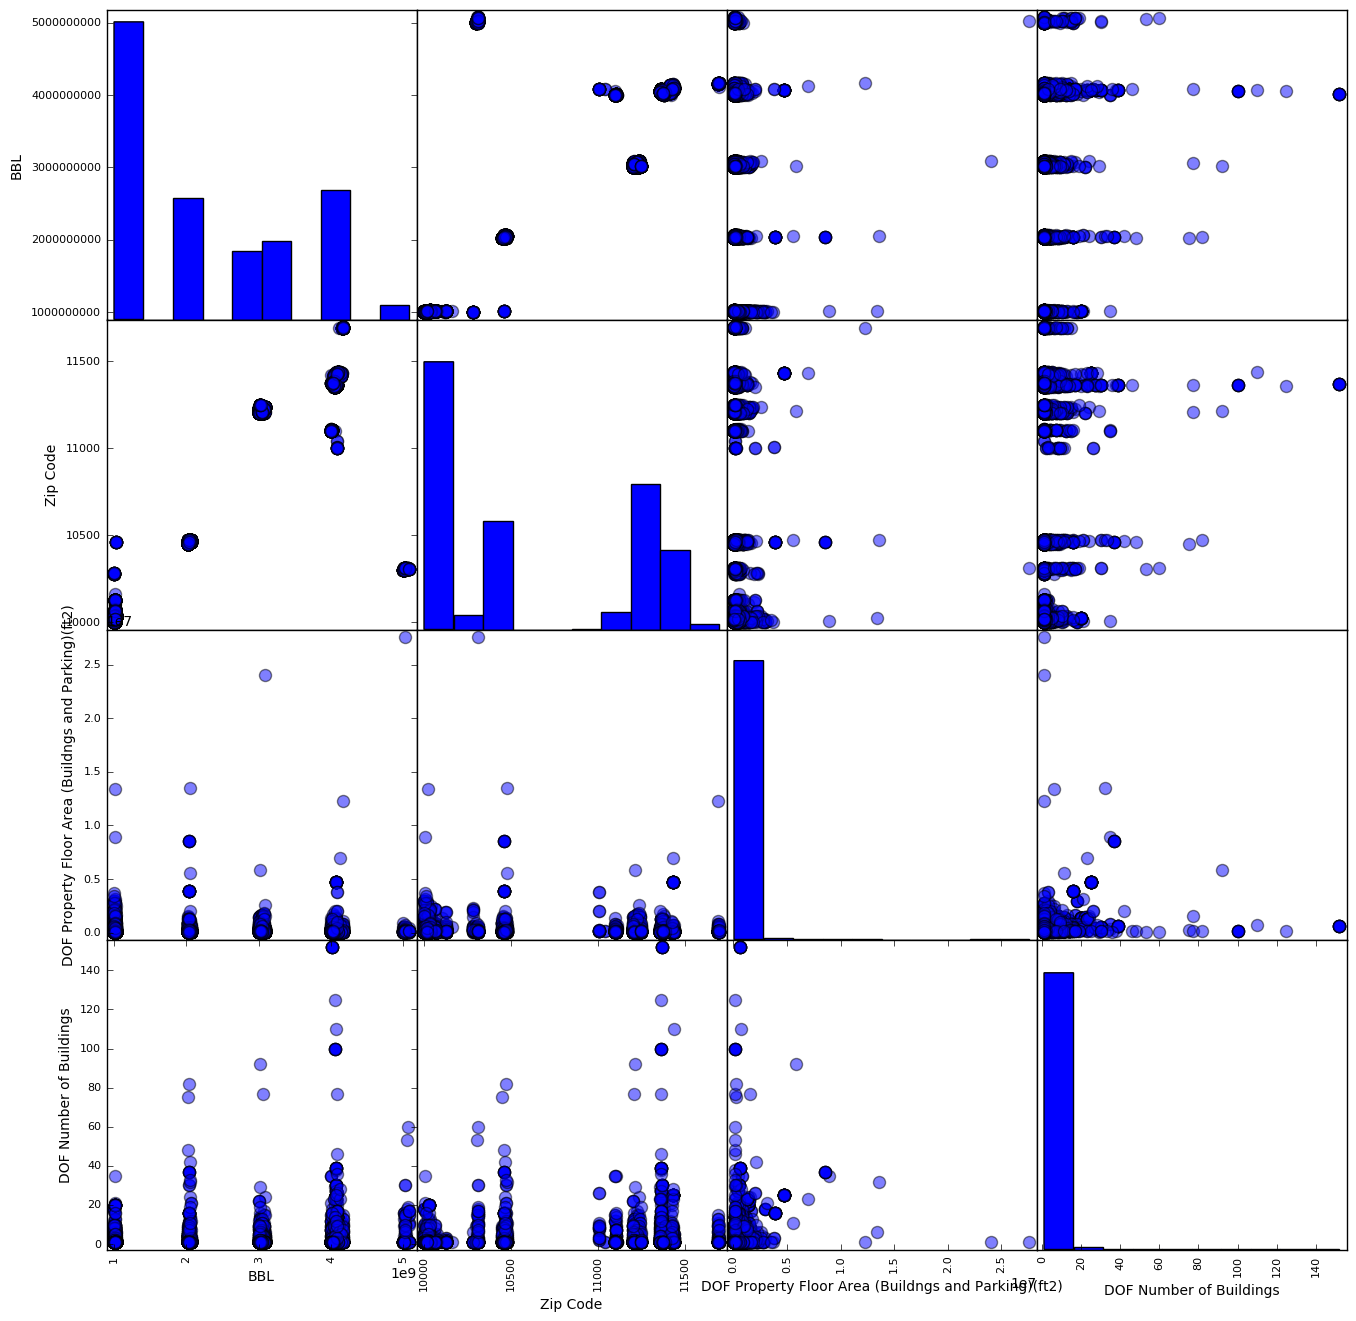

In [175]:
pd.scatter_matrix(nrg, s=300, figsize=(16, 16))
pl.show()

#### Figure 1: scatter matrix of all numerical values in the files.

In [176]:
bsize = bsize.loc[:,['BBL', 'UnitsRes', 'UnitsTotal']]

## Convert and Merge Data

In [200]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False
    
def convert(columns):
    for s in columns:
        indx = (np.vectorize(canconvert)(nrg[s]))
        nrg[s][~indx] = float('NaN')
        nrg[s] = nrg[s].astype(float)

In [203]:
convert(['Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)'])

In [211]:
bsize.BBL = bsize.BBL.astype(float);

In [229]:
nrg.rename(columns = {'Reported Property Floor Area (Building(s)) (ft²)': 'Area(ft2)'}, inplace = True)

In [234]:
bblnrgdata = pd.merge(left = nrg, right = bsize, on=["BBL"], how = "inner")

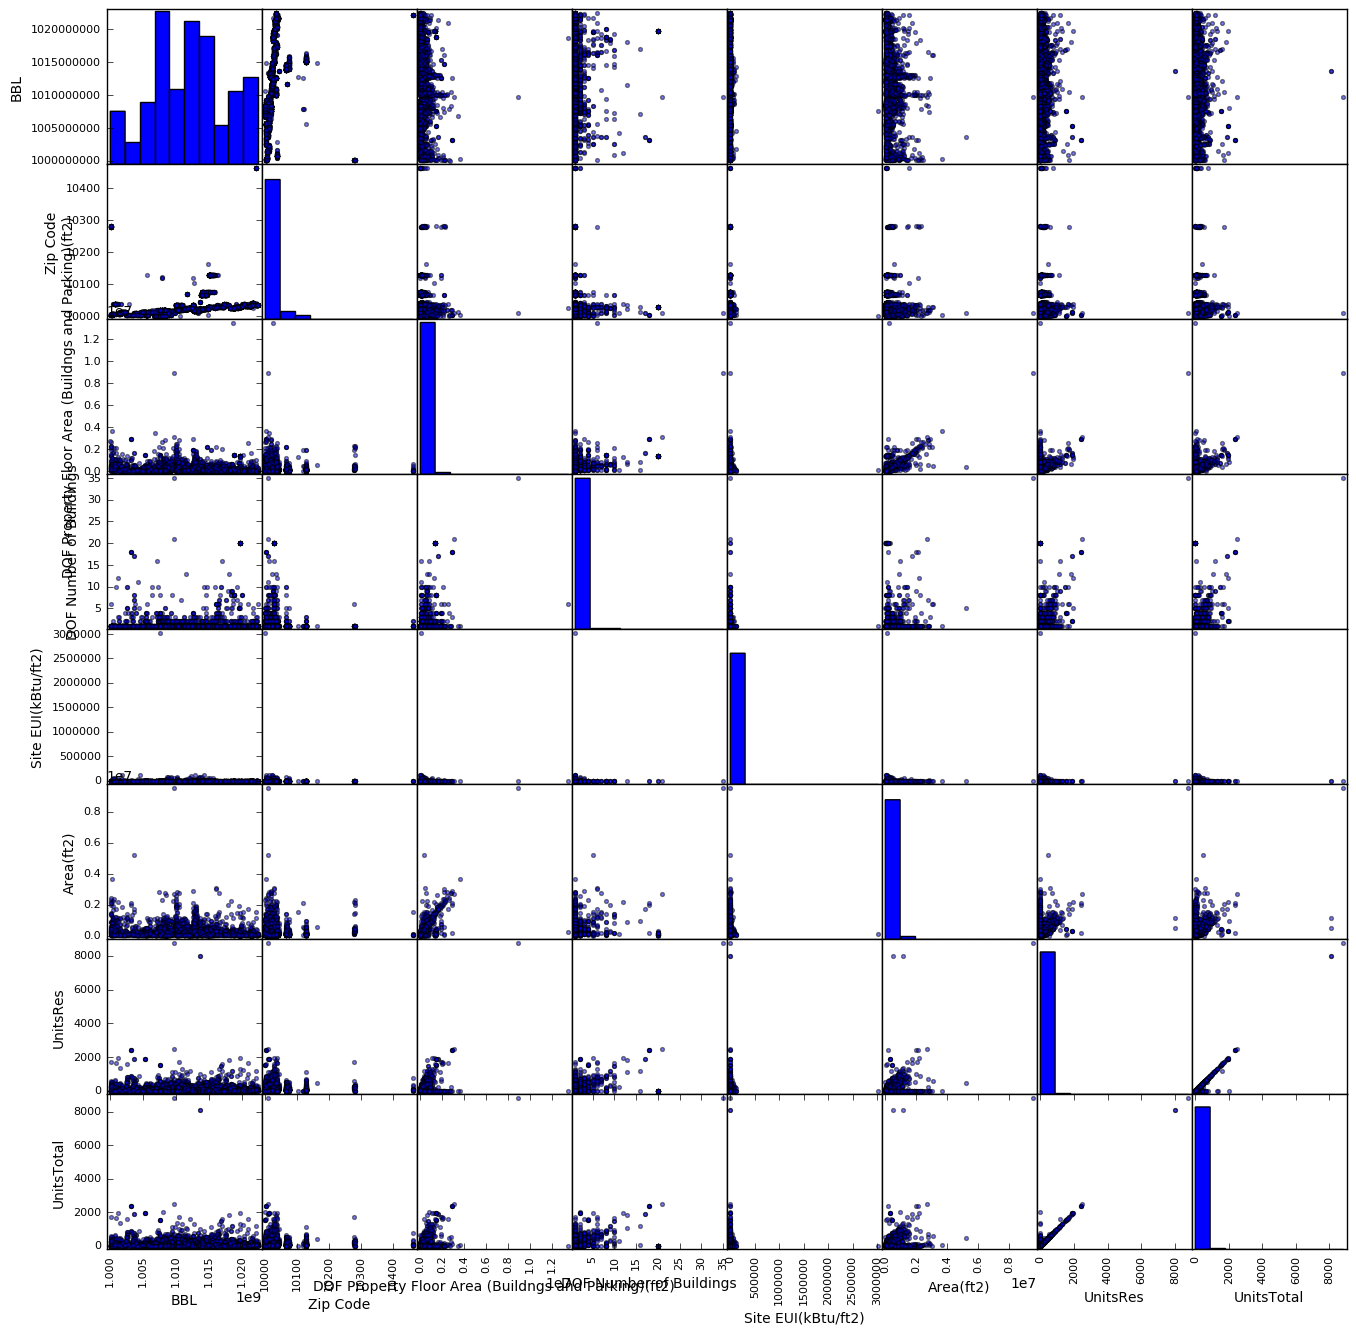

In [235]:
pd.scatter_matrix(bblnrgdata, s=30, figsize=(16, 16))
pl.show()

#### Figure 2: scatter matrix of all numerical values in bblnrgdata.

## Data Visualisation

In [236]:
bblnrgdata["Energy Total"] = bblnrgdata["Site EUI(kBtu/ft2)"].astype(float) * \
                             bblnrgdata["Area(ft2)"].astype(float)

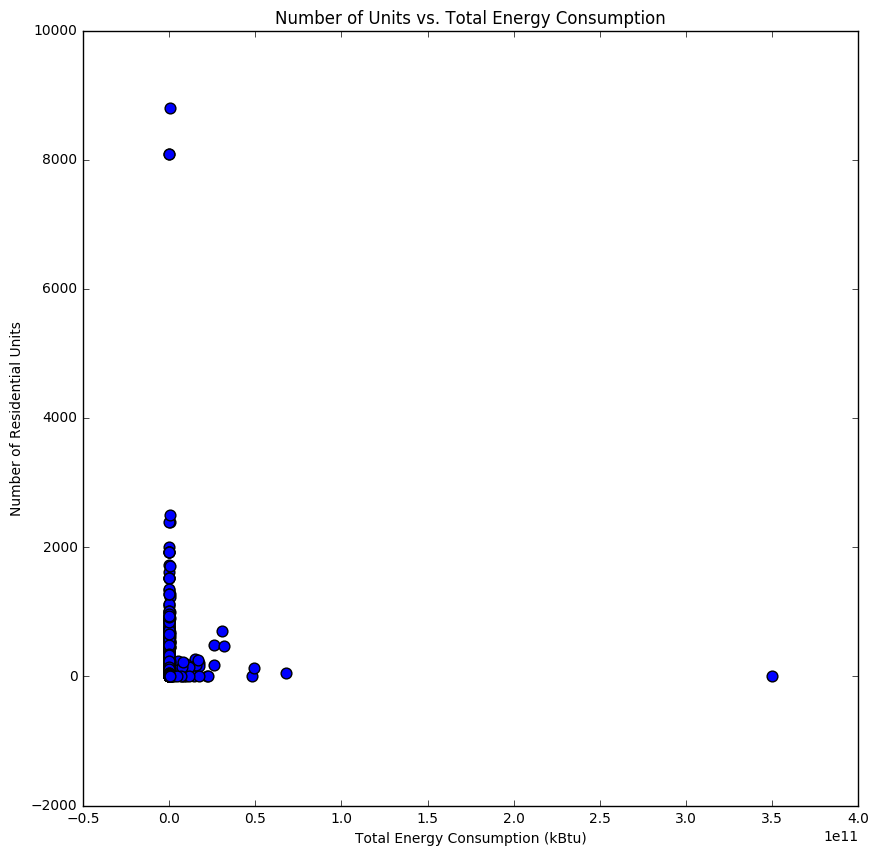

In [246]:
pl.figure(figsize=(10, 10))
pl.scatter(bblnrgdata["Energy Total"], bblnrgdata["UnitsTotal"], s = 60)
pl.xlabel("Total Energy Consumption (kBtu)")
pl.ylabel("Number of Residential Units")
pl.title("Number of Units vs. Total Energy Consumption", fontsize = 12)
pl.show()

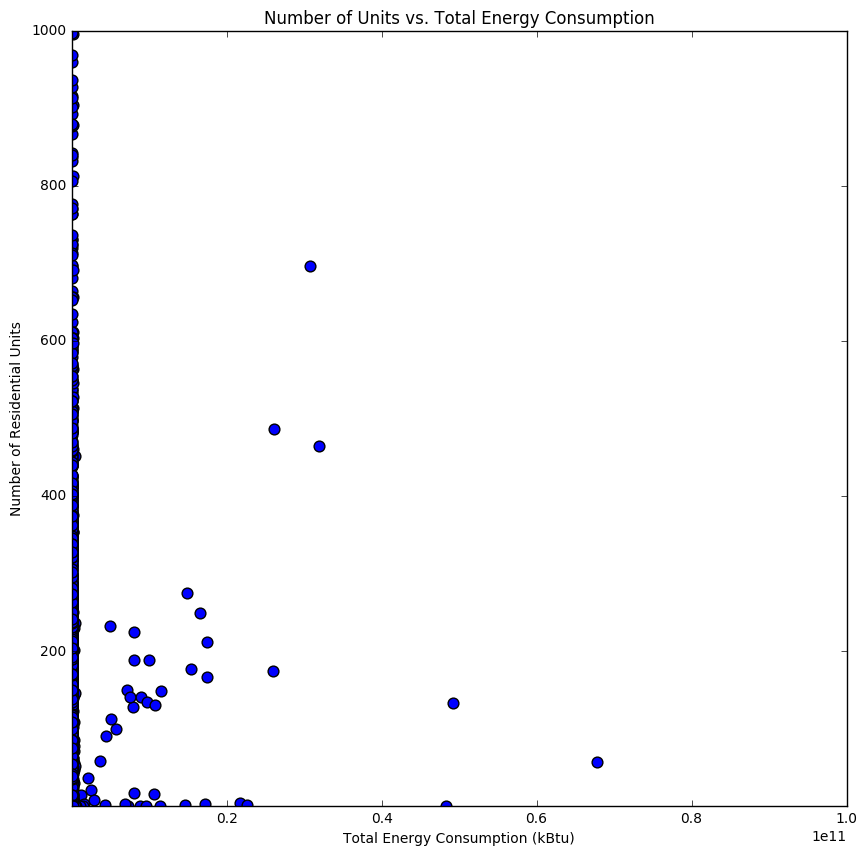

In [251]:
pl.figure(figsize=(10, 10))
pl.scatter(bblnrgdata["Energy Total"], bblnrgdata["UnitsTotal"], s = 60)
pl.xlabel("Total Energy Consumption (kBtu)")
pl.ylabel("Number of Residential Units")
pl.xlim(1000, 1e11)
pl.ylim(1, 1000)
pl.title("Number of Units vs. Total Energy Consumption", fontsize = 12)
pl.show()

In [260]:
bblnrgdata_cut = bblnrgdata[bblnrgdata["Energy Total"] > 1000]
bblnrgdata_cut = bblnrgdata_cut[bblnrgdata_cut["UnitsTotal"] > 10]
bblnrgdata_cut = bblnrgdata_cut[bblnrgdata_cut["UnitsTotal"] < 3000]

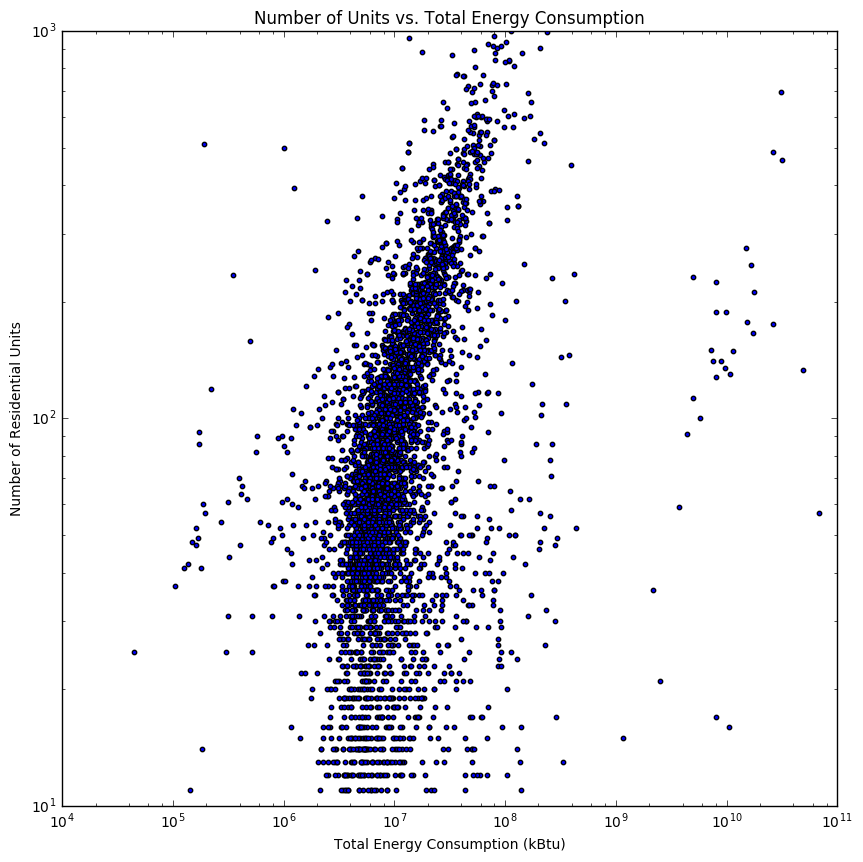

In [265]:
fig = bblnrgdata_cut.plot.scatter('Energy Total', 'UnitsTotal', s = 10, loglog = True, figsize = (10, 10))
pl.xlabel("Total Energy Consumption (kBtu)")
pl.ylabel("Number of Residential Units")
pl.xlim(1e4, 1e11)
pl.ylim(10, 1000)
pl.title("Number of Units vs. Total Energy Consumption", fontsize = 12)
pl.show()

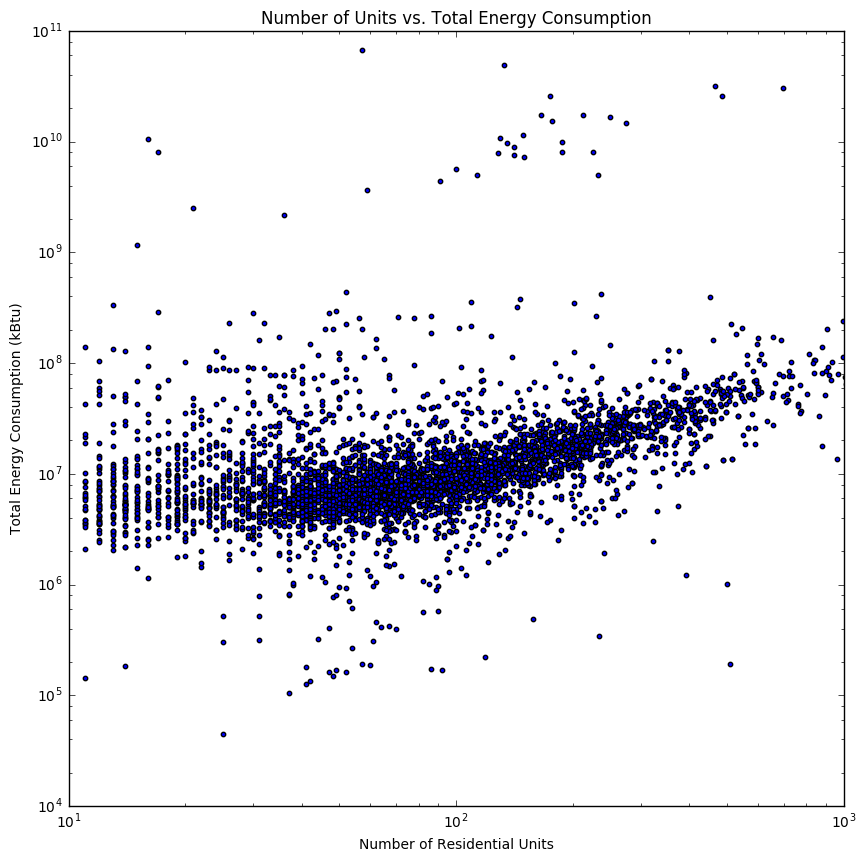

In [266]:
fig = bblnrgdata_cut.plot.scatter(y = 'Energy Total', x = 'UnitsTotal', s = 10, loglog = True, figsize = (10, 10))
pl.ylabel("Total Energy Consumption (kBtu)")
pl.xlabel("Number of Residential Units")
pl.ylim(1e4, 1e11)
pl.xlim(10, 1000)
pl.title("Number of Units vs. Total Energy Consumption", fontsize = 12)
pl.show()

## Data Regression

In [388]:
bblnrgdata_cut["logEnergyTot"] = np.log10(bblnrgdata_cut["Energy Total"])
bblnrgdata_cut["logUnitsTotal"] = np.log10(bblnrgdata_cut["UnitsTotal"])

In [389]:
Energy = bblnrgdata_cut["logEnergyTot"]
Units = bblnrgdata_cut["logUnitsTotal"]

In [390]:
def chisq(data, model):
    e = data / 2
    return ((model - data) ** 2 / e ** 2).sum()

def line(a, b, x):
    return a * x + b

def poly(a, b, c, x):
    return a * x ** 2 + b * x + c

In [391]:
lm1 = smf.ols(formula = "logEnergyTot ~ logUnitsTotal", data = bblnrgdata_cut).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:           logEnergyTot   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     890.1
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          8.74e-178
Time:                        21:42:47   Log-Likelihood:                -2559.3
No. Observations:                4263   AIC:                             5123.
Df Residuals:                    4261   BIC:                             5135.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         6.0863      0.033    187.229

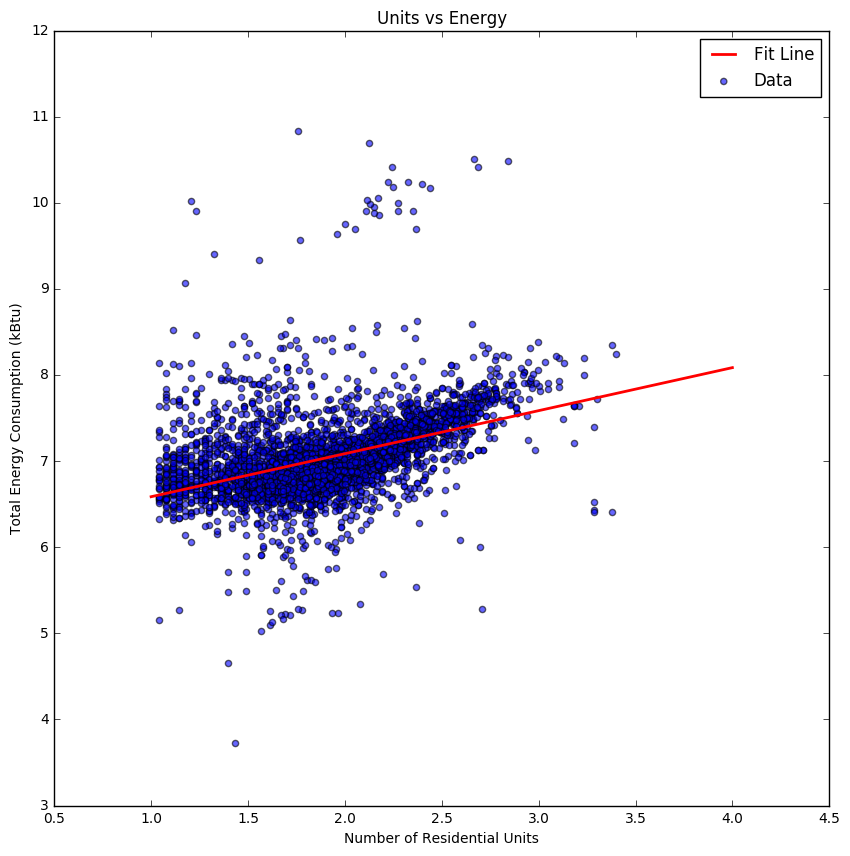

In [393]:
pl.figure(figsize = (10, 10))
pl.scatter(Units, Energy, alpha = 0.6, label = 'Data')
x_space = np.linspace(1,4,10)
pl.plot(x_space, line(lm1.params[1], lm1.params[0], x_space), 'r', lw = 2, label = 'Fit Line')
pl.ylabel("Total Energy Consumption (kBtu)")
pl.xlabel("Number of Residential Units")
pl.title('Units vs Energy')
pl.legend(loc = 'best', scatterpoints = 1)
pl.show()

In [394]:
lm2 = smf.ols(formula = "logUnitsTotal ~ logEnergyTot", data = bblnrgdata_cut).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:          logUnitsTotal   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     890.1
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          8.74e-178
Time:                        21:43:47   Log-Likelihood:                -1775.0
No. Observations:                4263   AIC:                             3554.
Df Residuals:                    4261   BIC:                             3567.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       -0.5343      0.082     -6.536   

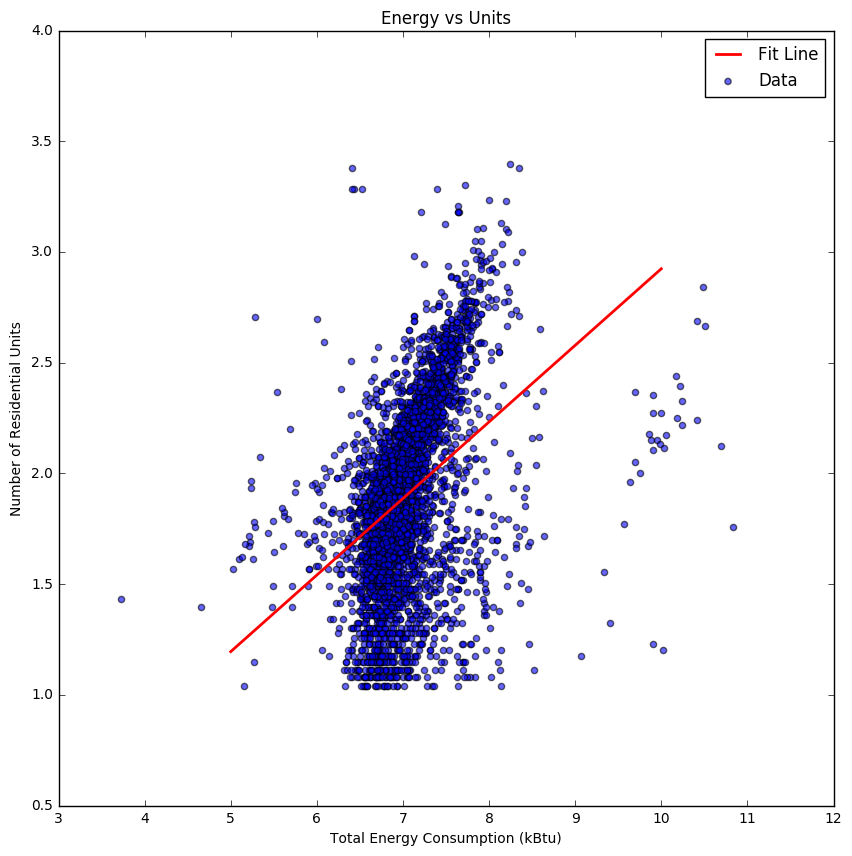

In [396]:
pl.figure(figsize = (10, 10))
pl.scatter(y = Units, x = Energy, alpha = 0.6, label = 'Data')
x_space = np.linspace(5, 10, 10)
pl.plot(x_space, line(lm2.params[1], lm2.params[0], x_space), 'r', lw = 2, label = 'Fit Line')
pl.xlabel("Total Energy Consumption (kBtu)")
pl.ylabel("Number of Residential Units")
pl.title('Energy vs Units')
pl.legend(loc = 'best', scatterpoints = 1)
pl.show()

In [397]:
print ("Chi squre for model: Units vs Energy")
print (chisq(Energy, lm1.predict()))
print ("Chi squre for model: Energy vs Units")
print (chisq(Units, lm2.predict()))

Chi squre for model: Units vs Energy
61.6775631385
Chi squre for model: Energy vs Units
931.495655744


### The Units vs Energy  model is better by calculating the chi square.

In [398]:
bblnrgdata_cut["logUT2"] = bblnrgdata_cut["logUnitsTotal"] * bblnrgdata_cut["logUnitsTotal"]

In [399]:
lm3 = smf.ols(formula = "logEnergyTot ~ logUnitsTotal + logUT2", data = bblnrgdata_cut).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:           logEnergyTot   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     581.7
Date:                Wed, 19 Oct 2016   Prob (F-statistic):          4.36e-224
Time:                        21:45:33   Log-Likelihood:                -2449.0
No. Observations:                4263   AIC:                             4904.
Df Residuals:                    4260   BIC:                             4923.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         7.6463      0.108     70.513

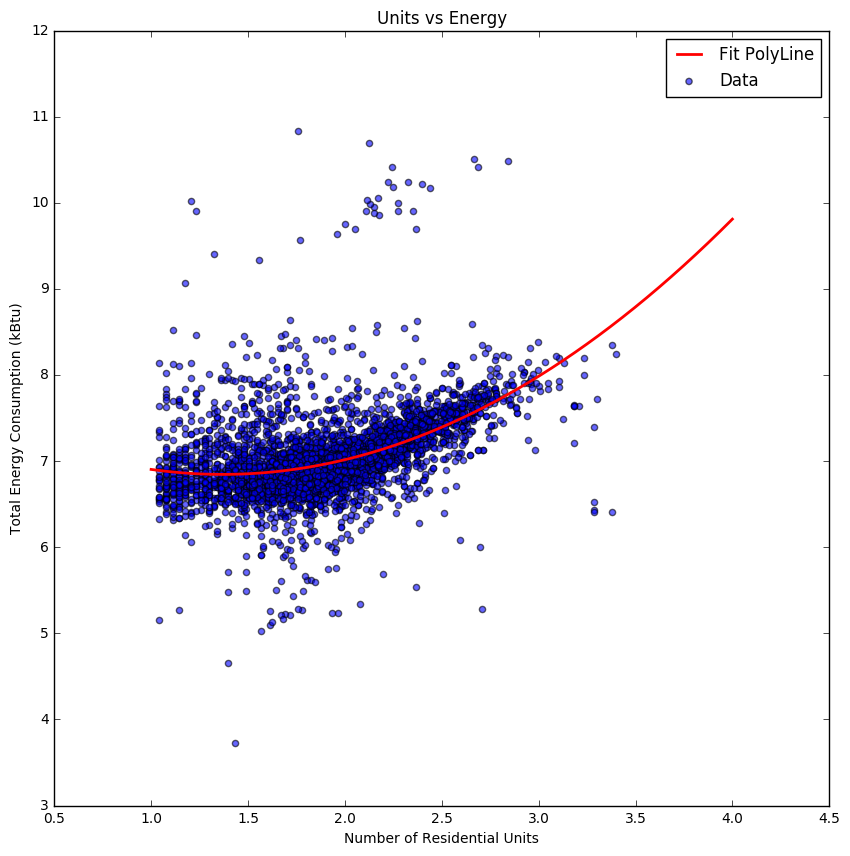

In [401]:
pl.figure(figsize = (10, 10))
pl.scatter(Units, Energy, alpha = 0.6, label = 'Data')
x_space = np.linspace(1, 4, 1000)
pl.plot(x_space, poly(lm3.params[2], lm3.params[1], lm3.params[0], x_space), 'r', lw = 2, label = 'Fit PolyLine')
pl.ylabel("Total Energy Consumption (kBtu)")
pl.xlabel("Number of Residential Units")
pl.title('Units vs Energy')
pl.legend(loc = 'best', scatterpoints = 1)
pl.show()

In [402]:
print ("LR : ", -2 * (-lm1.llf - (-lm3.llf)))
print ("LR from statsmodels:", lm3.compare_lr_test(lm1))

LR :  -220.629525367
LR from statsmodels: (220.62952536651846, 6.5927852373289776e-50, 1.0)


## Extra credit

In [403]:
errors = Energy / 2
def rss(a, b):
    return ((Energy - (Units * a + b)) ** 2 / errors ** 2).sum()

In [404]:
B = np.arange (-100, 100, 1)
A = np.arange(-50.0, 50.0, 0.5)
Lsurface = np.zeros((len(A), len(B)))

In [405]:
for i in range(len(A)):
    for j in range(len(B)):
        Lsurface[i][j] = rss(A[i], B[j])

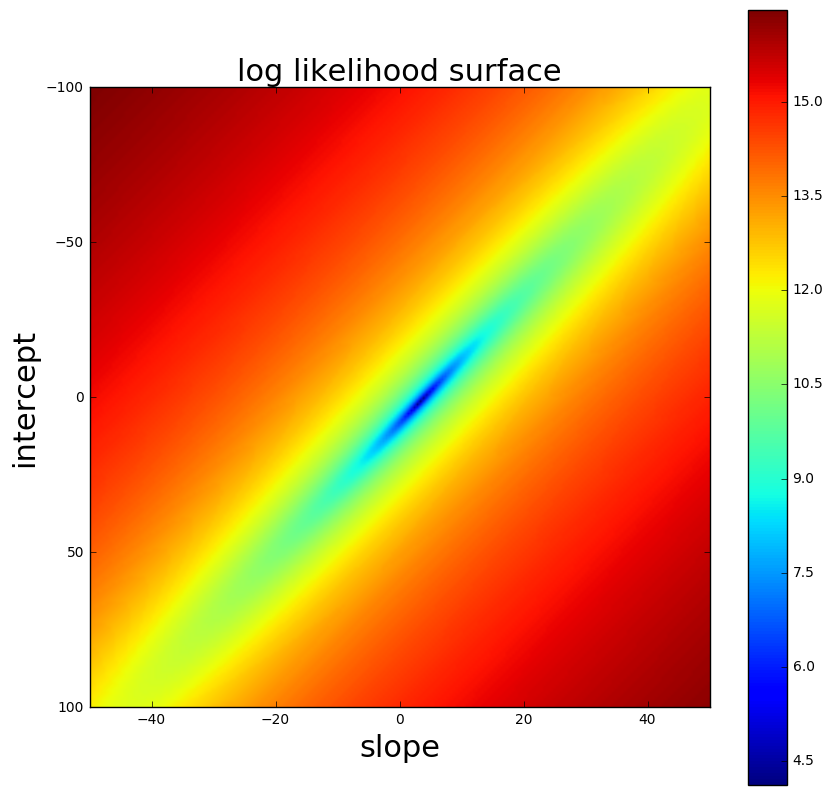

In [406]:
pl.figure(figsize = (10, 10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50, 50, 100, -100], aspect = 0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()
pl.show()